# Install & import libraries 📚

In [1]:
import sklearn
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import mat73
import os
import subprocess
import sys
from tsai.basics import *

from tsai.optuna import *
import papermill as pm
from tsai.optuna import run_optuna_study
from fastcore.basics import *
from torch.cuda import amp

In [2]:
# Check for GPUs
# Change the CUDA_VISIBLE_DEVICES values to numbers
# See (https://forums.fast.ai/t/exception-occured-in-lrfinder-when-calling-event-after-fit/104389/8)
if torch.cuda.is_available():
    #result = subprocess.check_output("nvidia-smi -L | grep -oE '[0-9]+:' | tr -d ':'", shell=True).decode("utf-8").strip()
    #os.environ['CUDA_VISIBLE_DEVICES'] = result
    #print(os.environ['CUDA_VISIBLE_DEVICES'])
    pass

In [3]:
print(torch.cuda.device_count())
torch.cuda.is_available()

1


True

# Model and Data Selection

In [4]:
# Define the available options
data_options = ["NRLMSISE", "TIEGCM"]

# Ask the user to select a data set
print("Please select a data set:")
for i, option in enumerate(data_options, 1):
    print(f"{i}. {option}")
data_choice = int(input("Enter the number of your choice: "))
data_name = data_options[data_choice - 1]

# Use the data_name in your naming path
path = f"data/{data_name}"

Please select a data set:
1. NRLMSISE
2. TIEGCM


## Load Scaled Data

In [5]:
# Parameters
freq = '1H'

fcst_history = 24*3*6 # 1/freq*18 (18 days) 432 steps in the past
fcst_horizon = 24*3  # 1/freq*3 (3 days) 72 steps in the future

#### Load Dataset and Splits

In [6]:
# Load dataframes
low_df = load_object('training/training_data/low_df_'+path+'.pkl')
low_df = low_df.reset_index(drop=True)

medium_df = load_object('training/training_data/medium_df_'+path+'.pkl')
medium_df = medium_df.reset_index(drop=True)

high_df = load_object('training/training_data/high_df_'+path+'.pkl')
high_df = high_df.reset_index(drop=True)

# Load splits
low_splits = load_object('training/splits/splits_lowSW_'+path+'.pkl')
medium_splits = load_object('training/splits/splits_mediumSW_'+path+'.pkl')
high_splits = load_object('training/splits/splits_highSW_'+path+'.pkl')

# Low SW
train_split = low_splits[0]
exp_pipe = load_object('training/exp_pipe/exp_pipe_lowSW_'+path+'.pkl')
low_df_scaled = exp_pipe.fit_transform(low_df, scaler__idxs=train_split)

# Medium SW
train_split = medium_splits[0]
exp_pipe = load_object('training/exp_pipe/exp_pipe_mediumSW_'+path+'.pkl')
medium_df_scaled = exp_pipe.fit_transform(medium_df, scaler__idxs=train_split)

# High SW
train_split = high_splits[0]
exp_pipe = load_object('training/exp_pipe/exp_pipe_highSW_'+path+'.pkl')
high_df_scaled = exp_pipe.fit_transform(high_df, scaler__idxs=train_split)

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.4s
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.2s
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s


### Apply a sliding window

We'll approach the time series forecasting task as a supervised learning problem. Remember that `tsai` requires that both inputs and outputs have the following shape: 

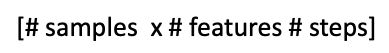

To get those inputs and outputs we're going to use a function called `prepare_forecasting_data` that applies a sliding window along the dataframe:

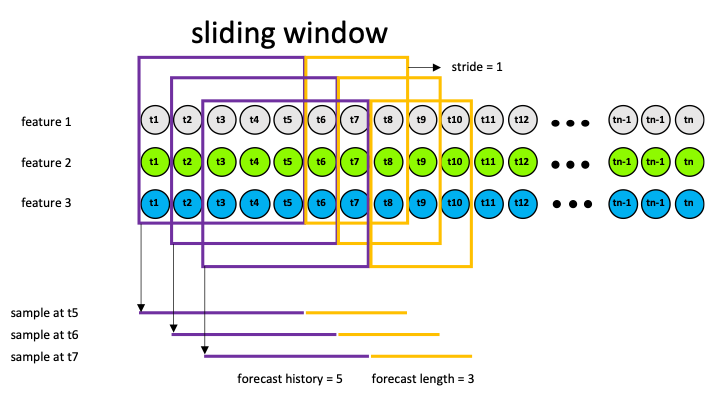

To use `prepare_forecasting_data` we need to define some settings: 

### Data

In [7]:
# Define the available options
data_options = ["low space weather", "medium space weather", "high space weather"]

# Ask the user to select a data set
print("Please select a data set:")
for i, option in enumerate(data_options, 1):
    print(f"{i}. {option}")
data_choice = int(input("Enter the number of your choice: "))
training_name = data_options[data_choice - 1]

Please select a data set:
1. low space weather
2. medium space weather
3. high space weather


In [8]:
if training_name == 'low space weather':
    df = low_df
    splits = low_splits
elif training_name == 'medium space weather':
    df = medium_df
    splits = medium_splits
elif training_name == 'high space weather':
    df = high_df
    splits = high_splits
else:
    print("Name not recognized")
    
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [9]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

# Prepare the forecaster 🏋️‍♂️

In [10]:
arch_config = dict(
    n_layers=1,  # number of encoder layers
    n_heads=2,  # number of heads
    d_model=20,  # dimension of model
    d_ff=28,  # dimension of fully connected network
    attn_dropout=0.0,  # dropout applied to the attention weights
    dropout=0.1,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=9,  # length of the patch applied to the time series to create patches
    stride=1,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [11]:
learn = TSForecaster(X, y, splits=splits, batch_size=8, path="models", pipelines=[exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph(), init=True)

In [12]:
learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 8 x 51 x 432)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 51 x 72         
RevIN                                     102        True      
____________________________________________________________________________
                     8 x 51 x 433        
ReplicationPad1d                                               
____________________________________________________________________________
                     8 x 9 x 425         
Unfold                                                         
____________________________________________________________________________
                     8 x 51 x 425 x 20   
Linear                                    200        True      
Dropout                                                        
Linear                                    420        True      
Linear                                    420        True      
Linear                                    420       

# Train model 🏃🏿‍♂️

⚠️ Whenever you need to look for a good learning rate to train a model you can use:
```python
lr_max = learn.lr_find().valley
```

In [13]:
import os
# Use this line to avoid memory overflow
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:100'

epoch,train_loss,valid_loss,mse,mae,time
0,0.359906,0.939255,0.939255,0.433489,03:51
1,0.542369,0.888750,0.888750,0.410535,03:48


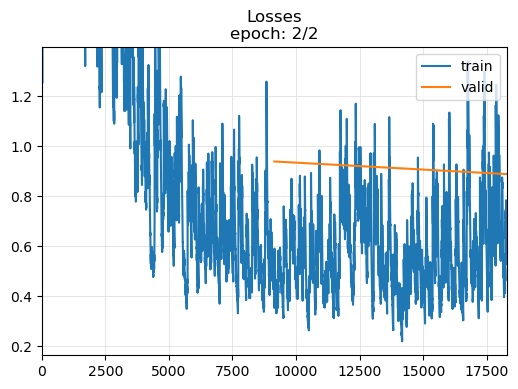

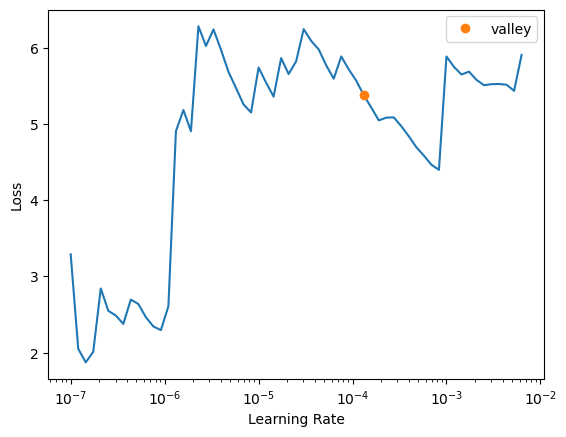

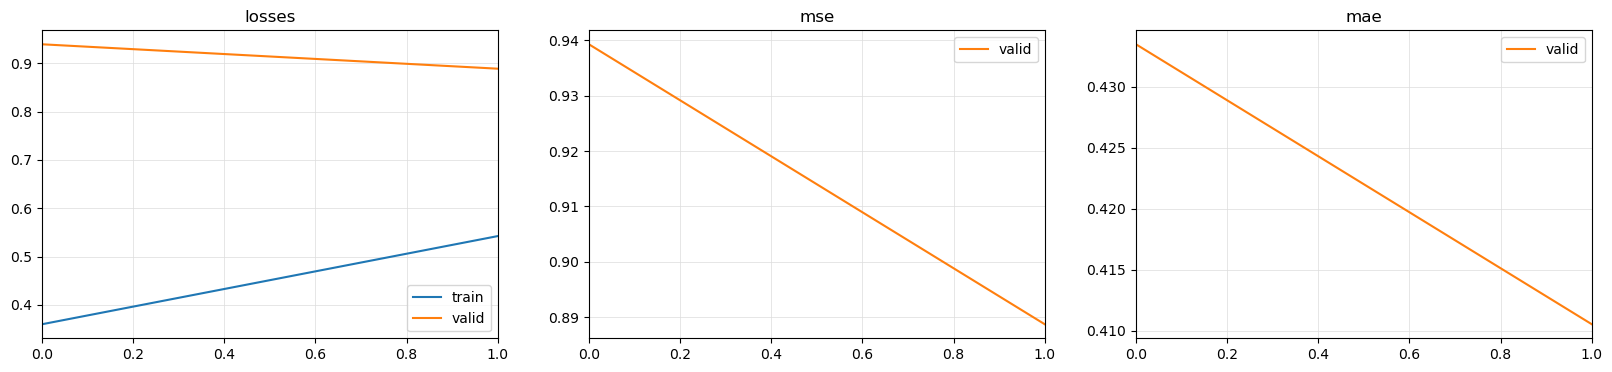

In [14]:
# Train the model
n_epochs = 2
lr_max = learn.lr_find().valley
learn.fit_one_cycle(n_epochs, lr_max=lr_max)


In [15]:
# Save the model
learn.export('patchTST_'+data_name+'_'+training_name+'.pt')